## Example of Image Resampling on Roman Simulated data using Cupy/CUDA

Author: Lei Hu <leihu@andrew.cmu.edu>  
Last Verified to run: 2024-09-09  

Use the Cupy/CUDA to perform image resampling for Roman simulated images.

#### Notable Requirements:  
cupy, astropy, numpy, matplotlib

#### Test Data
Object FileName: Roman_WAS_simple_model_H158_11832_15.fits

Target FileName: Roman_WAS_simple_model_H158_9758_15.fits

#### Remarks
  * The current example only demonstrate the bilinear interpolation function, but the framework can accommodate more resampling functions.

In [1]:
import time
import warnings
import cupy as cp
import numpy as np
from astropy.io import fits
from math import ceil, floor
from astropy.wcs import WCS, FITSFixedWarning

class Read_WCS:
    @staticmethod
    def RW(hdr, VERBOSE_LEVEL=2):
        with warnings.catch_warnings():
            if VERBOSE_LEVEL in [0, 1]: behavior = 'ignore'
            if VERBOSE_LEVEL in [2]: behavior = 'default'
            warnings.filterwarnings(behavior, category=FITSFixedWarning)

            if hdr['CTYPE1'] == 'RA---TAN' and 'PV1_0' in hdr:
                _hdr = hdr.copy()
                _hdr['CTYPE1'] = 'RA---TPV'
                _hdr['CTYPE2'] = 'DEC--TPV'
            else: _hdr = hdr
            w = WCS(_hdr)
        return w

# * read input FITS files
datadir = "/global/u1/l/leihu/JupyterLab/CUDASAMP/data"
#datadir = "/to/your/path/"
FITS_obj = datadir + "/Roman_WAS_simple_model_H158_11832_15.sciE.skysub.fits"  # object frame
FITS_targ = datadir + "/Roman_WAS_simple_model_H158_9758_15.sciE.skysub.fits"  # target frame 

PixA_obj = fits.getdata(FITS_obj, ext=0).T
PixA_targ = fits.getdata(FITS_targ, ext=0).T

hdr_obj = fits.getheader(FITS_obj, ext=0)
hdr_targ = fits.getheader(FITS_targ, ext=0)

w_obj = Read_WCS.RW(hdr=hdr_obj, VERBOSE_LEVEL=0)
w_targ = Read_WCS.RW(hdr=hdr_targ, VERBOSE_LEVEL=0)


In [2]:
# * maaping target pixel centers to the object frame
#   todo: not fast
NTX = int(hdr_targ["NAXIS1"]) 
NTY = int(hdr_targ["NAXIS2"])

_RR, _CC = np.mgrid[:NTX, :NTY]
XX_targ, YY_targ = _RR + 1., _CC + 1.
XY_targ = np.array([XX_targ.flatten(), YY_targ.flatten()]).T

# * get the projected coordinates
#   todo: this is too slow
XY_proj = w_obj.all_world2pix(w_targ.all_pix2world(XY_targ, 1), 1)
XX_proj = XY_proj[:, 0].reshape((NTX, NTY))
YY_proj = XY_proj[:, 1].reshape((NTX, NTY))

# * padding the object frame
KERHW = (1, 1)
NOX = int(hdr_obj["NAXIS1"]) 
NOY = int(hdr_obj["NAXIS2"])

PAD_WIDTH = (
    (np.max([ceil(0.5 - XX_proj.min()) + KERHW[0], 0]), np.max([floor(XX_proj.max() - NOX - 0.5) + 1 + KERHW[0], 0])),
    (np.max([ceil(0.5 - YY_proj.min()) + KERHW[1], 0]), np.max([floor(YY_proj.max() - NOY - 0.5) + 1 + KERHW[1], 0]))
)
print(PAD_WIDTH)

PixA_Eobj = np.pad(PixA_obj, PAD_WIDTH, mode='constant', constant_values=0.)
NEOX, NEOY = PixA_Eobj.shape

# * get the projected coordinates on extended object frame
XX_Eproj = XX_proj.copy()
XX_Eproj[:, :] += PAD_WIDTH[0][0]

YY_Eproj = YY_proj.copy()
YY_Eproj[:, :] += PAD_WIDTH[1][0]


((0, 1082), (1043, 0))


In [3]:
# * Cupy configuration
MaxThreadPerB = 8
GPUManage = lambda NT: ((NT-1)//MaxThreadPerB + 1, min(NT, MaxThreadPerB))
BpG_PIX0, TpB_PIX0 = GPUManage(NTX)
BpG_PIX1, TpB_PIX1 = GPUManage(NTY)
BpG_PIX, TpB_PIX = (BpG_PIX0, BpG_PIX1), (TpB_PIX0, TpB_PIX1, 1)

if not XX_Eproj.flags['C_CONTIGUOUS']:
    XX_Eproj = np.ascontiguousarray(XX_Eproj, np.float64)
    XX_Eproj_GPU = cp.array(XX_Eproj)
else: XX_Eproj_GPU = cp.array(XX_Eproj.astype(np.float64))

if not YY_Eproj.flags['C_CONTIGUOUS']:
    YY_Eproj = np.ascontiguousarray(YY_Eproj, np.float64)
    YY_Eproj_GPU = cp.array(YY_Eproj)
else: YY_Eproj_GPU = cp.array(YY_Eproj.astype(np.float64))

if not PixA_Eobj.flags['C_CONTIGUOUS']:
    PixA_Eobj = np.ascontiguousarray(PixA_Eobj, np.float64)
    PixA_Eobj_GPU = cp.array(PixA_Eobj)
else: PixA_Eobj_GPU = cp.array(PixA_Eobj.astype(np.float64))

PixA_resamp_GPU = cp.zeros((NTX, NTY), dtype=np.float64)

In [12]:
# * perform bilinear resampling using CUDA
# input: PixA_Eobj | (NEOX, NEOY)
# input: XX_Eproj, YY_Eproj | (NTX, NTY)
# output: PixA_resamp | (NTX, NTY)

# ** produce Iij, Tpq
_refdict = {'NTX': NTX, 'NTY': NTY, 'NEOX': NEOX, 'NEOY': NEOY}
_funcstr = r"""
extern "C" __global__ void kmain(double XX_Eproj_GPU[%(NTX)s][%(NTY)s], double YY_Eproj_GPU[%(NTX)s][%(NTY)s], 
    double PixA_Eobj_GPU[%(NEOX)s][%(NEOY)s], double PixA_resamp_GPU[%(NTX)s][%(NTY)s])
{
    int ROW = blockIdx.x*blockDim.x+threadIdx.x;
    int COL = blockIdx.y*blockDim.y+threadIdx.y;

    int NTX = %(NTX)s;
    int NTY = %(NTY)s;
    int NEOX = %(NEOX)s;
    int NEOY = %(NEOY)s;

    if (ROW < NTX && COL < NTY) {
        double x = XX_Eproj_GPU[ROW][COL];
        double y = YY_Eproj_GPU[ROW][COL];
        
        int r1 = floor(x) - 1;
        int c1 = floor(y) - 1;
        int r2 = r1 + 1;
        int c2 = c1 + 1;
        
        double dx = x - floor(x); 
        double dy = y - floor(y);
        
        double w11 = (1-dx) * (1-dy);
        double w12 = (1-dx) * dy;
        double w21 = dx * (1-dy);
        double w22 = dx * dy;

        PixA_resamp_GPU[ROW][COL] = w11 * PixA_Eobj_GPU[r1][c1] + w12 * PixA_Eobj_GPU[r1][c2] + 
            w21 * PixA_Eobj_GPU[r2][c1] + w22 * PixA_Eobj_GPU[r2][c2];
    }
}
"""
_code = _funcstr % _refdict
_module = cp.RawModule(code=_code, backend=u'nvcc', translate_cucomplex=False)

t0 = time.time()
_func = _module.get_function('kmain')
_func(args=(XX_Eproj_GPU, YY_Eproj_GPU, PixA_Eobj_GPU, PixA_resamp_GPU), block=TpB_PIX, grid=BpG_PIX)
print('MeLOn CheckPoint: Cuda resampling takes [%.6f s]' %(time.time() - t0))

# save the resampled image
PixA_resamp = cp.asnumpy(PixA_resamp_GPU)

# todo: refine the pixel filling
PixA_resamp[PixA_resamp == 0.] = np.nan
with fits.open(FITS_targ) as hdl:
    hdl[0].data[:, :] = PixA_resamp.T
    hdl.writeto(FITS_obj[:-5] + '.cuda_resamp.fits', overwrite=True)


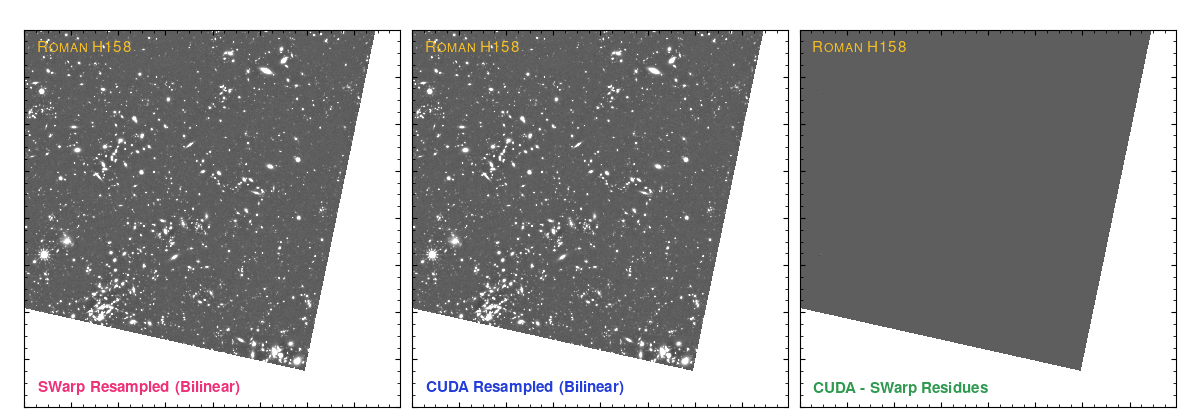

In [36]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from astropy import visualization as vs
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget

plt.rcParams.update({
   "text.usetex": True,
   "font.family": "sans-serif",
   "font.sans-serif": ["Helvetica"]})

vszs = vs.ZScaleInterval(
    n_samples=1000,
    contrast=0.25,
    max_reject=0.5,
    min_npixels=5,
    krej=2.5,
    max_iterations=5,
)

graycmap = matplotlib.colormaps.get_cmap('gray')
igraycmap = graycmap.reversed()

fig = plt.figure(figsize=(12, 4.2))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.03, wspace=0.03, \
    left=0.02, right=0.98, bottom=0.01, top=0.95)

axL = plt.subplot(131)
axR = plt.subplot(132)
axR2 = plt.subplot(133)

im_cuda = PixA_resamp.T
zmin, zmax = vszs.get_limits(im_cuda)
axR.imshow(im_cuda, origin='lower', cmap="gray", vmin=zmin, vmax=zmax)
 
im_swarp = fits.getdata(FITS_obj[:-5] + '.swarp_resamp.fits')  # swarp version
axL.imshow(im_swarp, origin='lower', cmap="gray", vmin=zmin, vmax=zmax)
axR2.imshow(im_cuda-im_swarp, origin='lower', cmap="gray", vmin=zmin, vmax=zmax)

for ax in [axL, axR, axR2]:
    MajorLocator = 512
    MinorLocator = 128
    ax.xaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.xaxis.set_minor_locator(MultipleLocator(MinorLocator))
    ax.yaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.yaxis.set_minor_locator(MultipleLocator(MinorLocator))
    ax.annotate(r'\textsc{Roman H158}', xy=(150, 3850), fontsize=11., color='#F5BE25')
    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, \
        labelleft=False, labelright=False, labelbottom=False, labeltop=False)

axL.annotate(r'\textbf{SWarp Resampled (Bilinear)}', xy=(150, 150), fontsize=11., color='#EE3277')
axR.annotate(r'\textbf{CUDA Resampled (Bilinear)}', xy=(150, 150), fontsize=11., color='#233ED9')
axR2.annotate(r'\textbf{CUDA - SWarp Residues}', xy=(150, 150), fontsize=11., color='#309A50')
plt.show()
